<a href="https://colab.research.google.com/github/Phantom1746a/Brain-Tumor-classification-using-transfer-learning-/blob/main/BrainTumorClassificationTransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image

In [2]:
for dirname, _, filenames in os.walk('/content/drive/MyDrive/braintumor/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/braintumor/Testing/glioma_tumor/image(21).jpg
/content/drive/MyDrive/braintumor/Testing/glioma_tumor/image(12).jpg
/content/drive/MyDrive/braintumor/Testing/glioma_tumor/image(34).jpg
/content/drive/MyDrive/braintumor/Testing/glioma_tumor/image(100).jpg
/content/drive/MyDrive/braintumor/Testing/glioma_tumor/image(27).jpg
/content/drive/MyDrive/braintumor/Testing/glioma_tumor/image(32).jpg
/content/drive/MyDrive/braintumor/Testing/glioma_tumor/image(1).jpg
/content/drive/MyDrive/braintumor/Testing/glioma_tumor/image(24).jpg
/content/drive/MyDrive/braintumor/Testing/glioma_tumor/image(2).jpg
/content/drive/MyDrive/braintumor/Testing/glioma_tumor/image(33).jpg
/content/drive/MyDrive/braintumor/Testing/glioma_tumor/image(17).jpg
/content/drive/MyDrive/braintumor/Testing/glioma_tumor/image(18).jpg
/content/drive/MyDrive/braintumor/Testing/glioma_tumor/image(19).jpg
/content/drive/MyDrive/braintumor/Testing/glioma_tumor/image(16).jpg
/content/drive/MyDrive/braintumor/T

Data Preparation
We are going to detect four different types of Brain Tumors. So, declare a variable called label like below.

In [3]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/braintumor','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/braintumor','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:50<00:00,  1.46it/s]


let’s define some colors which will help us with visualization.

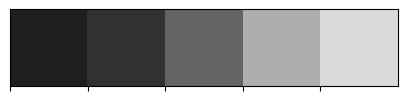

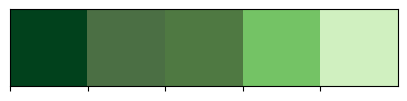

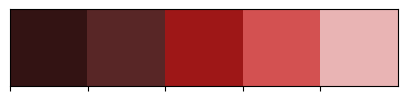

In [4]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

plot a few images for each label.

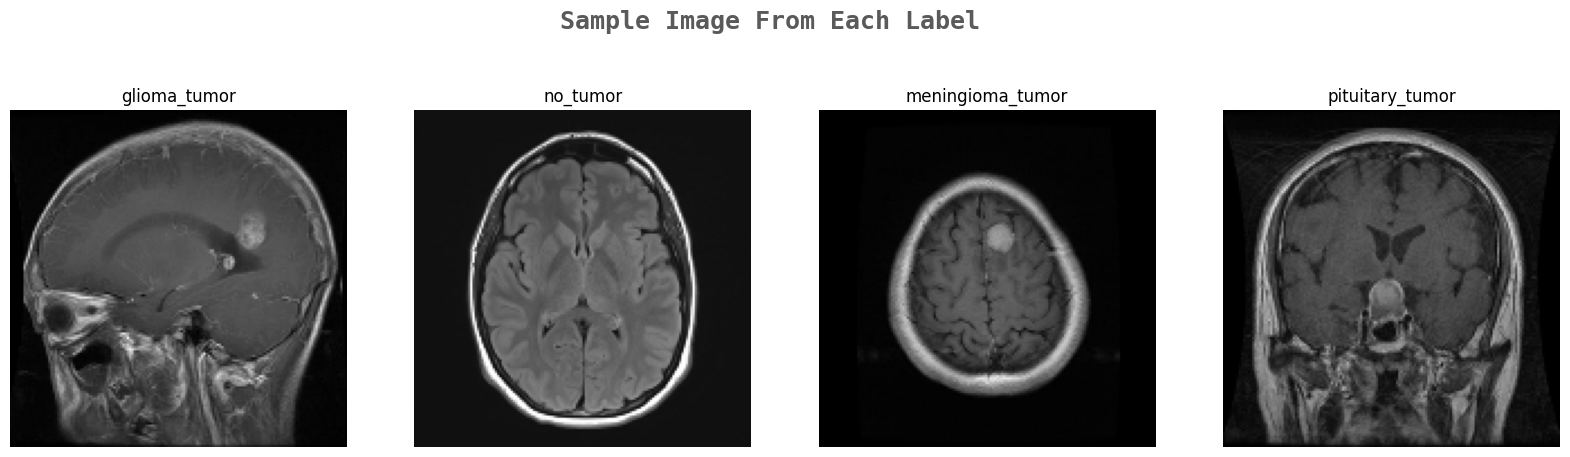

In [5]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

We will shuffle the x_train and y_train

In [6]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)
X_train.shape

(3264, 150, 150, 3)

we will split our dataset into Training and Testing sets. Test set being the 10% of the Training set.



In [7]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)
#The test_size parameter helps us to set the size of the testing set (0.1 = 10%).


One Hot Encoding.

In [8]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

What is Transfer Learning?
Deep Convolution Neural Network models may take days or even months to train on very large datasets. A simple way to short-cut this process is to re-use the model weights from pre-trained models that were developed for standard computer vision benchmark datasets,
Pre-trained Model: We have a deep learning model that's already been trained on a massive dataset for a similar task. Think of it as our experienced chefs.
Transfer Knowledge: We take this pre-trained model and "borrow" its knowledge, particularly the earlier layers that deal with general concepts like edges and shapes in images, or grammar in language. These are like the fundamental cooking skills.
Fine-tuning: We then adjust the final layers of the model to focus on the specific task we want it to perform. This is like the chef learning a new dish, using their existing skills as a base.

We are going to use the EfficientNetB0 model which will use the weights from the ImageNet dataset.

In [9]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16705208/16705208 [==============================] - 2s 0us/step


Now, we are going to append our custom layers to the EfficientNetB0 model.

In [10]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 150, 150, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 150, 150, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 150, 150, 3)          0         ['normalization[0][0]']   

We have used a few layers and explanations of every layer are given below:
GlobalAveragePooling2D: his layer acts similarly to the Max Pooling layer in CNNs, the only difference being that it uses the Average values instead of the Max value while pooling
Dropout: This layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
Dense : A simple Neural Network layer and also our output layer which classifies the image into 1 of the 4 possible classes.

In [12]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [13]:
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto',verbose=1)

In [14]:
log_dir = "logs"
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
tensorboard = TensorBoard(log_dir=log_dir)

In [16]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32, callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 [==============================] - ETA: 0s - loss: 0.4668 - accuracy: 0.8328
Epoch 1: val_accuracy improved from -inf to 0.78571, saving model to effnet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


83/83 [==============================] - 58s 199ms/step - loss: 0.4668 - accuracy: 0.8328 - val_loss: 0.8909 - val_accuracy: 0.7857 - lr: 0.0010
Epoch 2/12
83/83 [==============================] - ETA: 0s - loss: 0.2041 - accuracy: 0.9289
Epoch 2: val_accuracy improved from 0.78571 to 0.92177, saving model to effnet.h5
83/83 [==============================] - 12s 143ms/step - loss: 0.2041 - accuracy: 0.9289 - val_loss: 0.2722 - val_accuracy: 0.9218 - lr: 0.0010
Epoch 3/12
83/83 [==============================] - ETA: 0s - loss: 0.1102 - accuracy: 0.9618
Epoch 3: val_accuracy did not improve from 0.92177
83/83 [==============================] - 11s 134ms/step - loss: 0.1102 - accuracy: 0.9618 - val_loss: 0.3038 - val_accuracy: 0.8980 - lr: 0.0010
Epoch 4/12
83/83 [==============================] - ETA: 0s - loss: 0.0994 - accuracy: 0.9641
Epoch 4: val_accuracy did not improve from 0.92177

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
83/83 [===============

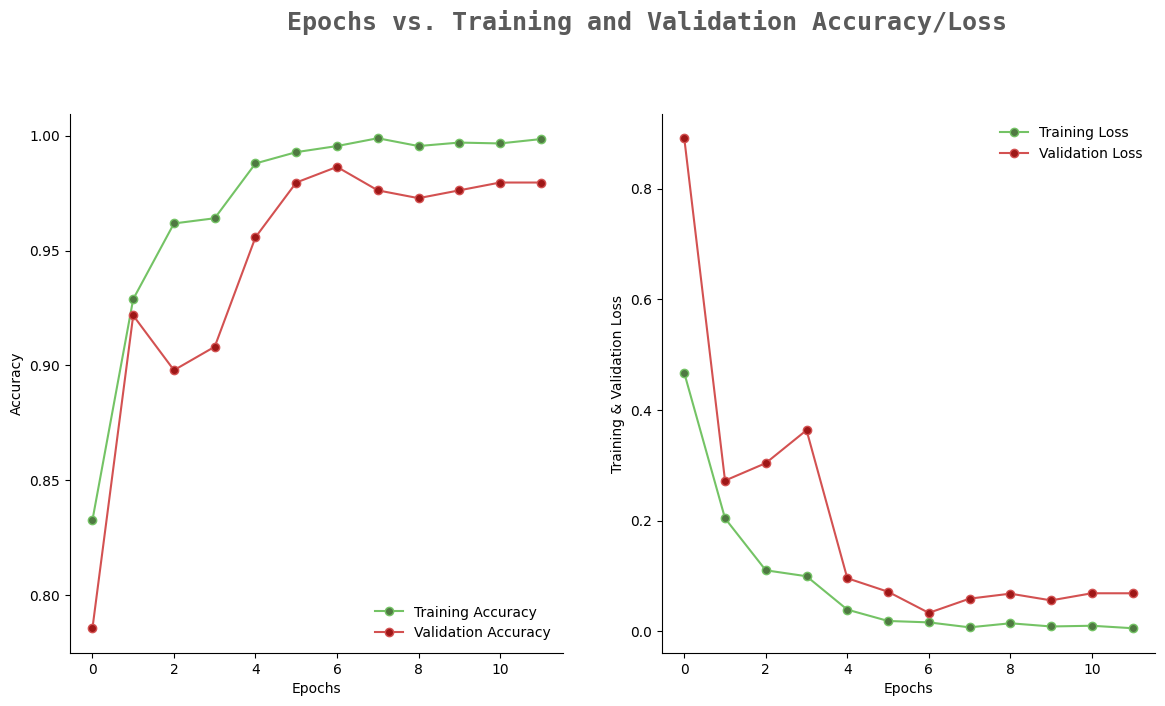

In [18]:


epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

Prediction

In [19]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)


11/11 [==============================] - 3s 123ms/step


Evaluation

In [20]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        93
           1       0.98      0.98      0.98        51
           2       0.95      0.97      0.96        96
           3       0.98      0.98      0.98        87

    accuracy                           0.97       327
   macro avg       0.97      0.97      0.97       327
weighted avg       0.97      0.97      0.97       327



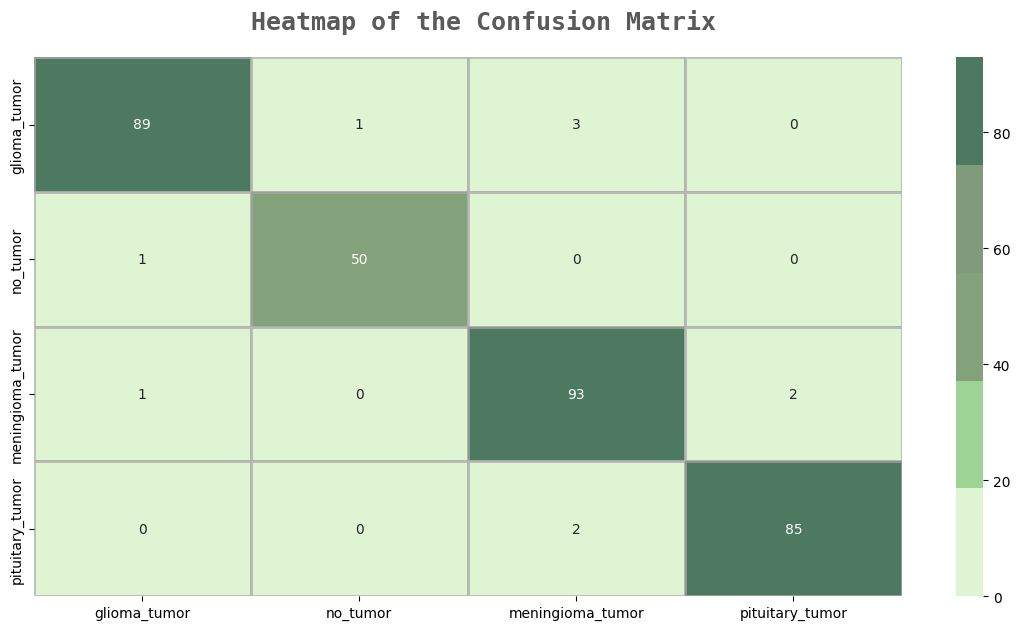

In [21]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [23]:
model.save('brainTumorDetection')

Predicting Image

In [31]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load and preprocess the image
img_path = "/content/drive/MyDrive/braintumor/Training/meningioma_tumor/m (10).jpg"
img = image.load_img(img_path, target_size=(150, 150))  # Adjust target_size as needed
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize pixel values

# Make the prediction
pred = model.predict(img_array)

# Interpret the prediction (assuming categorical classification)
predicted_class = np.argmax(pred, axis=1)
print(predicted_class)

1/1 [==============================] - 0s 53ms/step
[1]


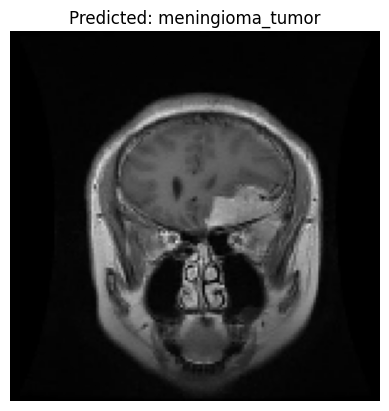

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image


labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']  # Replace with your actual labels
predicted_label = labels[predicted_class[0]]

# Display the image with the predicted label
plt.imshow(img_array[0])
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()

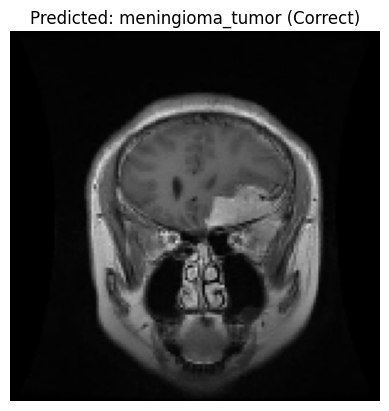

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
import os

# ... (previous code for loading, preprocessing, and prediction)

# Determine the label
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']  # Replace with your actual labels
predicted_label = labels[predicted_class[0]]

# Extract the true label from the file path
true_label = os.path.basename(os.path.dirname(img_path))

# Check if the prediction is accurate
accuracy_message = "Correct" if predicted_label == true_label else "Incorrect"

# Display the image with prediction and accuracy
plt.imshow(img_array[0])
plt.title(f"Predicted: {predicted_label} ({accuracy_message})")
plt.axis('off')
plt.show()